## Imports

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import hdbscan
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import numpy as np
from copy import deepcopy
import time
import random

from methods import *
from visualisation import *

from river import forest
from protree.data.stream_generators import Sine, Plane, RandomTree
from protree.data.river_generators import Sea, Rbf, Stagger, Mixed
from protree.detectors import RaceP
from protree.explainers import APete
from full_window_storage import FullWindowStorage

## Prepare dataset

In [40]:
# Prepare dataset (with duplication for recurrence)
block_size = 1000
ds = Rbf(drift_position=[28_000, 52_000, 70_000], drift_duration=7_000, seed = random.randint(1,10000))

dataset = []
for i in range(100):
    x_block, y_block = zip(*ds.take(block_size))
    dataset.append([x_block, y_block])

## Run prototype creation and windows storage

In [41]:
# Setup model
model = forest.ARFClassifier()

# Run with full window storage
storage = FullWindowStorage()

def create_prototypes_for_stream(model, storage, dataset):
    print("Running with independent prototype selection...")
    for i in range(len(dataset)):
        if i % 10 == 0:
            print(f'{i}/{len(dataset)}')

        x_block, y_block = dataset[i]
        
        # Learn from data
        for x, y in zip(x_block, y_block):
            model.learn_one(x, y)
        
        # Create fresh prototype selector with current model state
        current_explainer = APete(model=model, alpha=0.01)
        
        # Select prototypes independently for this window only
        current_prototypes = current_explainer.select_prototypes(x_block, y_block)
        
        # Store window data
        storage.store_window(
            iteration=i,
            x=x_block,
            y=y_block,
            prototypes=current_prototypes,
            explainer=None,
            drift=False  # No drift detection being used
        )

    print(f"\nStored {len(storage.get_all_iterations())} windows")

create_prototypes_for_stream(model, storage, dataset)
matrix = storage.compute_distance_matrix(measure="centroid_displacement")
print(f"Matrix shape: {matrix.shape}")

Running with independent prototype selection...
0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100

Stored 100 windows
Matrix shape: (100, 100)


## Show distance between windows

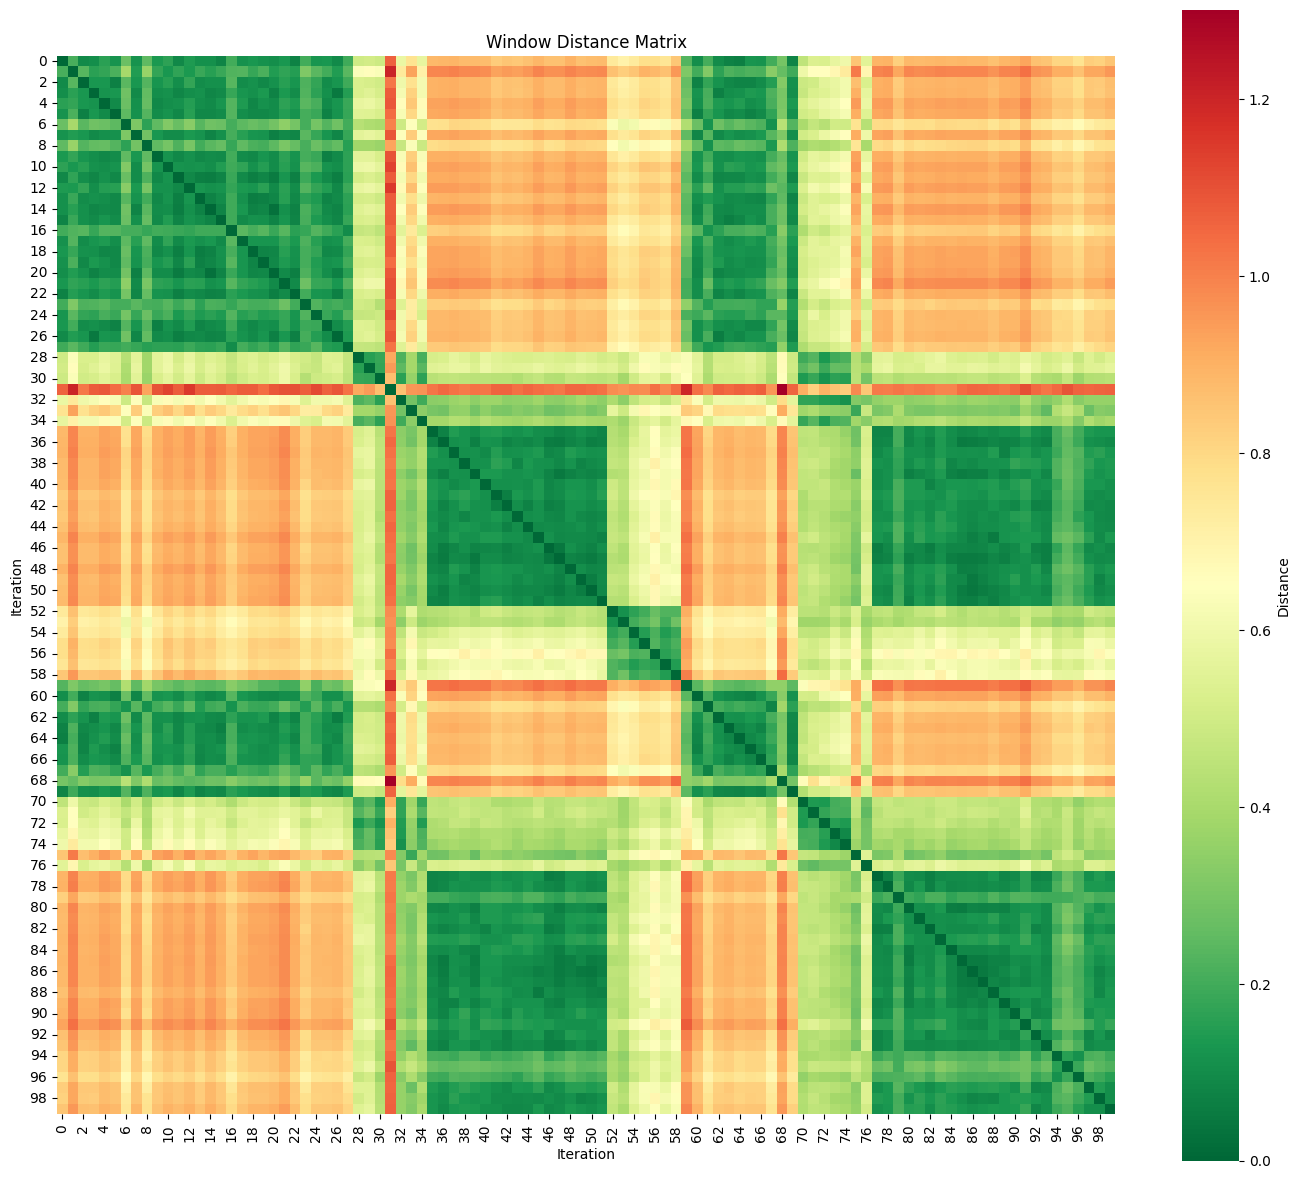

In [42]:
visualize_distance_matrix(matrix)

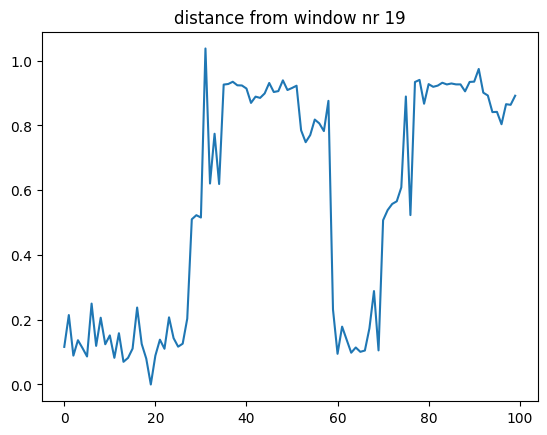

In [43]:
show_distance_median(storage, 19, k=1)

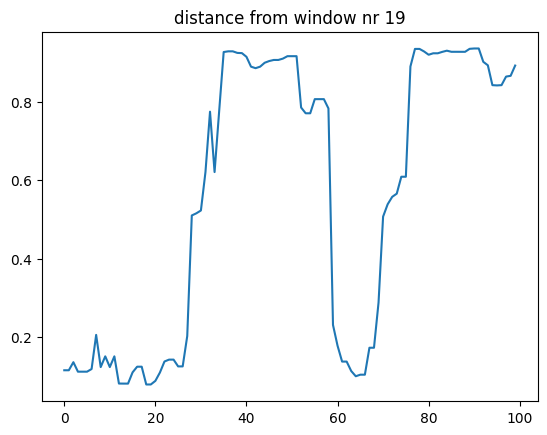

In [44]:
show_distance_median(storage, 19)

## Cluster windows into concepts

We can see which windows are in the same concept even when they are not close to each other temporaly. Also by looking at the place in time when windows change concepts we can accurately detect drifts.

In [45]:
labels = cluster_windows(matrix)
print(labels)

drift_locations = get_drift_from_clusters(labels)
print(drift_locations)

print(np.unique_counts(labels))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[28, 35, 52, 59, 70, 77]
UniqueCountsResult(values=array([0, 1, 2, 3]), counts=array([39,  7, 14, 40]))


### Lets see how applying 3x3 median filter will affect the results

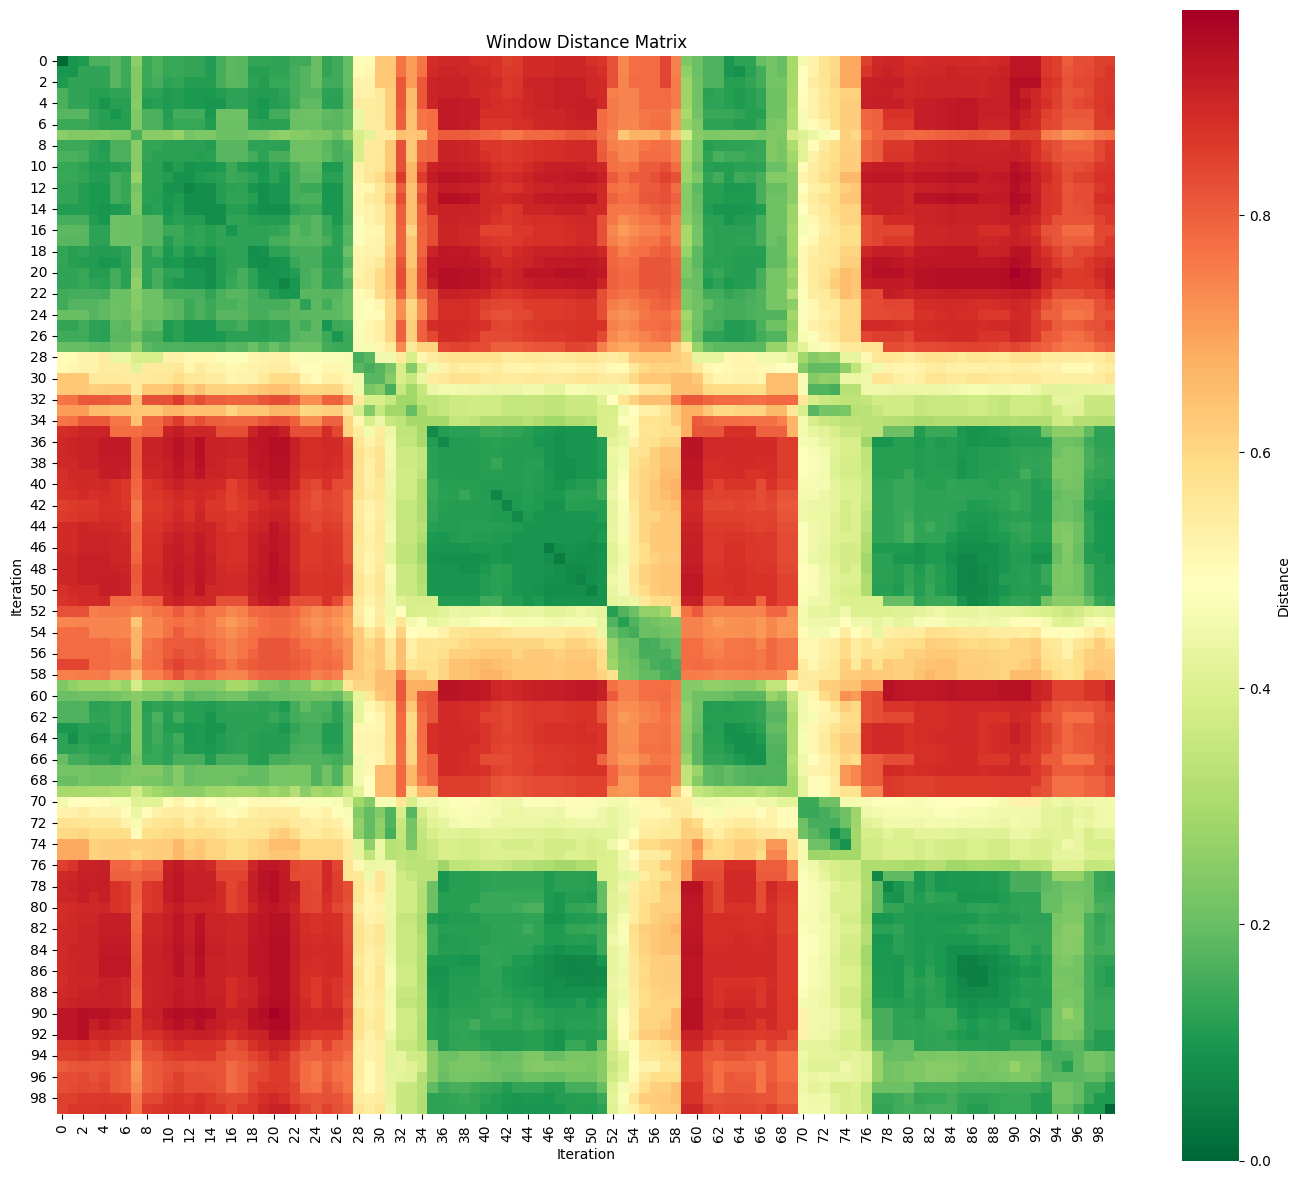

In [46]:
visualize_distance_matrix(pd.DataFrame(median_mask_2d(matrix)))

In [47]:
labels = cluster_windows(matrix, median_mask_width=3)
print(labels)

drift_locations = get_drift_from_clusters(labels)
print(drift_locations)

print(np.unique_counts(labels))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[28, 35, 52, 59, 70, 76]
UniqueCountsResult(values=array([0, 1, 2, 3]), counts=array([39,  7, 13, 41]))


### Lets check how clustering will perform after some noise

In [48]:
# Disturb the distance matrix to see how the clustering does under less friendly cirmustances
matrix_noise = matrix.copy()

# Add windows that are similar to all other windows
distance_to_all = 0.25
for i in range(20):
    matrix_noise.loc[len(matrix_noise)] = [distance_to_all]*len(matrix_noise)
    matrix_noise[len(matrix_noise)] = [distance_to_all] * len(matrix_noise)


n = matrix_noise.shape[0]

# Create noise matrix
noise = np.random.uniform(-0.07, 0.07, size=(n, n))

# Make noise symmetric
noise = (noise + noise.T) / 2

# Zero out the diagonal
np.fill_diagonal(noise, 0.0)

# Add symmetric noise to df
matrix_noise = matrix_noise + noise

# Ensure diagonal is 0 in result as well (if required)
np.fill_diagonal(matrix_noise.values, 0.0)



labels_noise = cluster_windows(matrix_noise)
print(labels_noise)

drift_locations_noise = get_drift_from_clusters(labels_noise)
print(drift_locations_noise)

print(np.unique_counts(labels_noise))

[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  1  1  1  1  1  1  1  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3 -1 -1  0  0  0  0 -1 -1  2  2  2  2  2  2  2  2  2  2  1  1
  1  1  1 -1 -1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3 -1 -1 -1  0  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1]
[28, 35, 54, 60, 70, 77, 103, 104, 117]
UniqueCountsResult(values=array([-1,  0,  1,  2,  3]), counts=array([23,  5, 13, 38, 41]))


## Check accuracy of clustering

In [49]:
# Get true concept labels
def get_region(n):
    if n < 28 or (n >= 100 and n < 128):
        return 0
    if (n >= 28 and n < 52) or (n >= 128 and n < 152):
        return 1
    if (n >= 52 and n < 70) or (n >= 152 and n < 170):
        return 2
    if (n>=70 and n<100) or (n>=170 and n<200):
        return 3
    print(n)
    raise Exception(f"{n} does not correspond to any data distribution")

def get_region(n):
    if n < 28 or (n >= 100 and n < 128):
        return 0
    if (n >= 28 and n < 52) or (n >= 128 and n < 152):
        return 1
    if (n >= 52 and n < 70) or (n >= 152 and n < 170):
        return 0
    if (n>=70 and n<100) or (n>=170 and n<200):
        return 1
    print(n)
    raise Exception(f"{n} does not correspond to any data distribution")

true_concept_list = np.array([get_region(i) for i in range(len(labels))])

In [50]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(true_concept_list, labels)

0.6739530162839616

In [51]:
from sklearn.metrics import adjusted_mutual_info_score

adjusted_mutual_info_score(true_concept_list, labels)

0.7317660057268331

In [52]:
from sklearn.metrics import fowlkes_mallows_score

fowlkes_mallows_score(true_concept_list, labels)

0.8204601798573463

In [53]:
clustered_labels_accuracy(labels, true_concept_list)

np.float64(0.8)

## Lets check how well the windows are separable into 'different' and 'similar' based on the distance matrix at different threshold levels

Unprocessed:

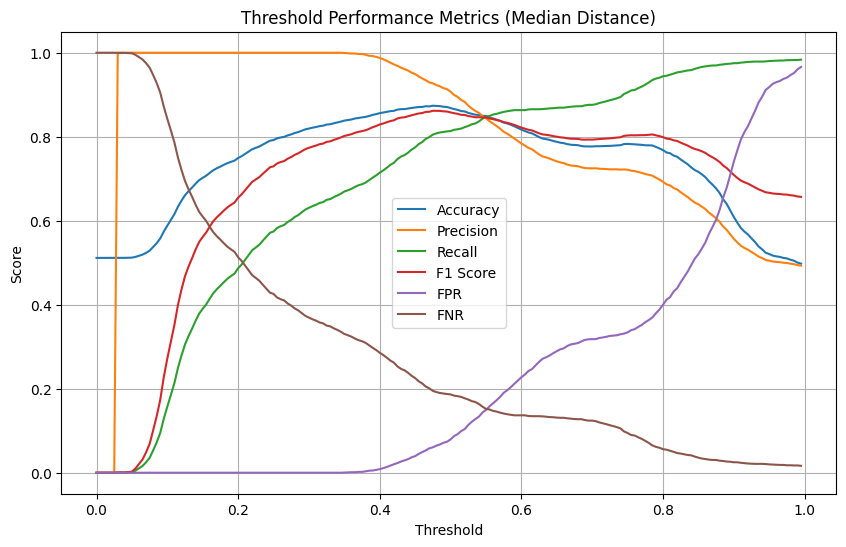

Best Threshold by F1:
{'threshold': 0.47500000000000003, 'accuracy': 0.8738404452690167, 'precision': 0.9271137026239067, 'recall': 0.8050632911392405, 'fpr': 0.060459492140266025, 'fnr': 0.1949367088607595, 'f1': 0.8617886178861788}


In [54]:
plot_threshold_analysis_results(threshold_test(matrix, true_concept_list))

1d median mask of lenght 3 applied to reduce noise:

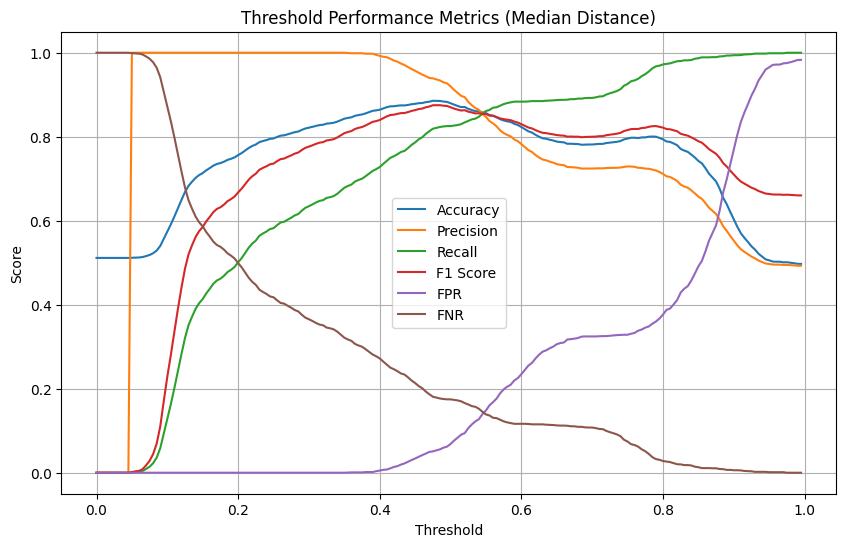

Best Threshold by F1:
{'threshold': 0.485, 'accuracy': 0.8851783137497423, 'precision': 0.9339396840593586, 'recall': 0.8232067510548523, 'fpr': 0.05562273276904474, 'fnr': 0.17679324894514767, 'f1': 0.8750840995738954}


In [55]:
plot_threshold_analysis_results(threshold_test(matrix, true_concept_list, median_mask_dimensions=(1,3)))

# Visualization

## Compare prototypes of windows

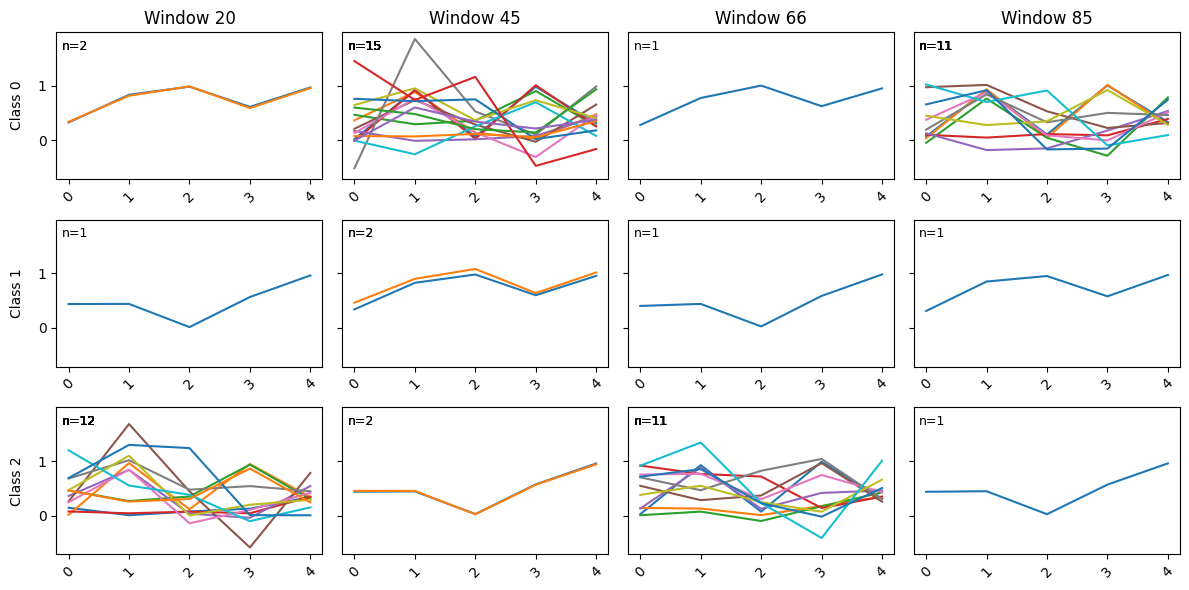

In [56]:
windows_to_compare = [20, 45, 66, 85]
plot_prototype_comparison(storage, windows_to_compare)

#TODO info about prototypes (like amount in each plot)
# TODO graph of amount of prototypes for each class over time
# idea: tabs: matrix, inpect window, global statistics (z osią czsu w róźnych kolorach w zależności od conceptu z clustrów), compare windows
# ^ Somehow tell the user where drift is (global statistics tab probably)
# also tab for running this